## Prepare samples for chip order
- Author: Linna An
- version: 2021, Feb 11th
    - fix error on pandas
- Acknowledge: Chris Norn, Gyu Rie Lee
- 1. This notebook prepared for samples which require 2-piece assembly
- 2. Material: all pdbs for order
- 3. Rough Steps:
    1. pdbs will be translated into amino acid sequences
    2. aa sequences will be sorted into different subpools (1000 sequence each) based on length
    3. Within each subpool, sequences will be pad to the same length
    4. Each subpool will be translated to DNA sequences
    5. Each translated subpool will be added with required adaptors
    6. Each prepared subpool will be measured for its overlap diversity

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import os, subprocess, glob, re, gzip, math, shutil, itertools, sys, time, math, string
from shutil import copyfile
from numpy import *
from numpy import linalg
sys.path.append('/home/linnaan/lib/')
from libSlurm_public import make_submit_file #version not containing email alert
from libSlurm_public import make_dist_plots

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import IFrame

- Provide directory containing all directories storing all pdbs to order

In [236]:
PARENT_DIR = '/home/linnaan/NTF2/FOL_NTF2_binder/for_order/210118_batch1_agilent'
os.chdir(PARENT_DIR)
%pwd

'/mnt/home/linnaan/NTF2/FOL_NTF2_binder/for_order/210118_batch1_agilent'

### Translate designs from pdb to sequences

In [218]:
def translate(pdb):
    PDB2SEQ = '/home/linnaan/software/pdb2seq'
    result = subprocess.run([PDB2SEQ,pdb], stdout=subprocess.PIPE)
    aa_seq = result.stdout.decode('utf-8').rstrip()
    aa_length = len(aa_seq)
    return aa_seq, aa_length

- Go through each sub-directory, translate all designs into pdb sequences, and save in a single file

In [219]:
pdb_list = []
for num,pdb in enumerate(glob.glob('./*/*.pdb')):
    aa_seq, aa_length = translate(pdb)
    pdb_list.append([pdb,aa_seq,aa_length])
df = pd.DataFrame(pdb_list,columns=['design','seq','length'])

In [220]:
df.tail()

,design,seq,length
6673,./201203_NTF2hb_FOL_resample_sel_lddt0.8/326_H...,PDERKIKDWIRRYLEALDRKDLDELKELFTKDWTFHETGGRTFTNI...,121
6674,./201203_NTF2hb_FOL_resample_sel_lddt0.8/329_H...,MSQEEVKELLKRFYEALNQRDADKAASLFTPDATVHFFHGSQQDDI...,123
6675,./201203_NTF2hb_FOL_resample_sel_lddt0.8/70_Y8...,DSEEQIKELIKEFYRAINERDLDALSELLHDDAQLHQSNGQTFDNK...,119
6676,./201203_NTF2hb_FOL_resample_sel_lddt0.8/221_H...,PASEEEIREWLKQFYEAFNNKDWKKLADLMAPDARMEVTESNGQNY...,124
6677,./201203_NTF2hb_FOL_resample_sel_lddt0.8/413_H...,PDEKEMEEEVREFDKRRVEAINNRDLEKVKSLVHPDATFRLARTQK...,128


In [221]:
df.to_csv('./all_pdb')

In [222]:
#remove duplicate
df = df.drop_duplicates(subset='seq')
print(len(df))
df.to_csv('./all_pdb_nonredundant')
print(len(df))
df

3997
3997


,design,seq,length
0,./210112_NTF2_FOL_TD_triad_sel_lddt0.8_part1/9...,PGEETAEEQIREWKKRFIEAENNNDRDKVKELLTDDATFHMGDGRT...,125
1,./210112_NTF2_FOL_TD_triad_sel_lddt0.8_part1/8...,PEEDEMKEAVKKILQRLSEALNRGDAEAIARLLDEDWTFHDAEPRT...,125
2,./210112_NTF2_FOL_TD_triad_sel_lddt0.8_part1/1...,PGEETAEEQIREWKKRFIEAENNNDRDKVKELLTDDATFHDAQGQT...,125
3,./210112_NTF2_FOL_TD_triad_sel_lddt0.8_part1/2...,PKEKEMEEKVREIKKQQIEALNKNDWDTFKKLMDDSTMHIPFRGRT...,125
4,./210112_NTF2_FOL_TD_triad_sel_lddt0.8_part1/5...,PKEKEMEEKVREIKKQLDEALNKNDWDTFKKLMDDSTMHIPDRGRT...,125
...,...,...,...
6673,./201203_NTF2hb_FOL_resample_sel_lddt0.8/326_H...,PDERKIKDWIRRYLEALDRKDLDELKELFTKDWTFHETGGRTFTNI...,121
6674,./201203_NTF2hb_FOL_resample_sel_lddt0.8/329_H...,MSQEEVKELLKRFYEALNQRDADKAASLFTPDATVHFFHGSQQDDI...,123
6675,./201203_NTF2hb_FOL_resample_sel_lddt0.8/70_Y8...,DSEEQIKELIKEFYRAINERDLDALSELLHDDAQLHQSNGQTFDNK...,119
6676,./201203_NTF2hb_FOL_resample_sel_lddt0.8/221_H...,PASEEEIREWLKQFYEAFNNKDWKKLADLMAPDARMEVTESNGQNY...,124


### Split to different subpools

In [223]:
# change order based on length
df = df.sort_values(by='length',ascending=True)
print(len(df))
df

3997


,design,seq,length
6546,./201203_NTF2hb_FOL_resample_sel_lddt0.8/106_H...,ASEEEIRELIRRLVEAFNKGDMDAIKELYDDGATVHINNGRTFTSK...,113
6502,./201203_NTF2hb_FOL_resample_sel_lddt0.8/184_H...,PDTEEIERFVRRFIEEVDKSGDADAAKSYYDKDARIDFSGGQTYSL...,113
5978,./201203_NTF2hb_FOL_resample_sel_lddt0.8/324_H...,TSEEEIREAVQRYYEAWNHKDMDKLLSLIHDDWQNDVYNLTTKEEY...,113
6131,./201203_NTF2hb_FOL_resample_sel_lddt0.8/25_H9...,ASEEEIRELIRRLVEAFNKGDMDAIKELYDDGATVHFWNGRTFTSK...,113
5883,./201203_NTF2hb_FOL_resample_sel_lddt0.8/281_H...,PISEEQIKEWVKRWVEAFNKGDMDKLMSLYSEGSRFHNSATGKTYD...,114
...,...,...,...
2831,./201215_NTF2_FOL_PDBrif_sel_lddt0.8/267_S125_...,MDESEAKEAIKEWLRRYYEAWNKGDADALRELLHPDVTFHFSSEGQ...,131
5527,./201203_NTF2hb_FOL_sel_lddt0.8/171_H107_N4.18...,PGEEEARRQAEEIARRFYEALNNKDWEAIARLVDDNAKFTFTEDQR...,131
5973,./201203_NTF2hb_FOL_resample_sel_lddt0.8/281_H...,ASEKELREAVREWLRRYYEALNHKDLDKVVSLFDDDWRVDFSKTGK...,132
6672,./201203_NTF2hb_FOL_resample_sel_lddt0.8/388_H...,ASEKELREAVREWLRRYYEALNHKDLDKVVSLFDDDWRVDISETGK...,132


/software/conda/envs/pyrosetta/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


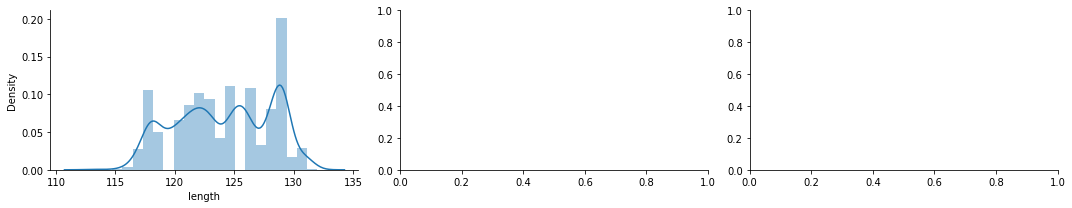

In [224]:
#check aa length distribution
make_dist_plots(df,['length'])

### decide subpools based on total length and legth distribution
- each subpool (aka oligos with the same adaptors) should less than 1000 oligos. To many oligos will decrease assembly effciency.
- the smaller each pool, the better, but don't do too small, since it will take long time PCR to enrich your libraries.

In [225]:
def merge_length(df_in):
    '''
    pad all sequences in each subpool to the same length as the max of the design in that subpool
    '''
    linker = 'GSSGGSSGGSSG'
    min_length,max_length = list(df_in['length'])[0],list(df_in['length'])[-1]
    for num,pdb in enumerate(list(df_in['design'])):
        length = df_in.loc[num].at['length']
        if length != max_length:
            orig_seq = df_in.loc[num].at['seq']
            new_seq = orig_seq + linker[0:(max_length-length)]
            df_in.iloc[num,df_in.columns.get_loc('seq')] = new_seq
            df_in.iloc[num,df_in.columns.get_loc('length')] = len(new_seq)
    return df_in

In [226]:
# Decide subpool split and pad to longest sequence in each subpool
df_list = []
subpool_list = [799,799,799,800,800] #input the number you want in each subpool
start = 0
for num,pool_size in enumerate(subpool_list):
    end = start + pool_size
    print('--------process seq %s ~ %s ------'%(start,end))
    df_subpool = pd.DataFrame()
    df_subpool = df.iloc[start:end]
    print('subpool size: %d'%len(df_subpool))
    min_length,max_length = list(df_subpool['length'])[0],list(df_subpool['length'])[-1]
    print('Before padding: min %d max %d'%(min_length,max_length))
    df_subpool = df_subpool.reset_index()
    df_subpool = merge_length(df_subpool)
    df_subpool = df_subpool.sort_values(by='length',ascending=True)
    min_length,max_length = list(df_subpool['length'])[0],list(df_subpool['length'])[-1]
    print('after padding: min %d max %d'%(min_length,max_length))
    fp = open('./subpool_{}'.format(num),'w')
    fp.write('\n'.join('%s %s'%(df_subpool.iloc[num].at['design'],df_subpool.iloc[num].at['seq']) for num in range(len(df_subpool))))
    fp.close()
    start = end
df_subpool.tail()

--------process seq 0 ~ 799 ------
subpool size: 799
Before padding: min 113 max 120
after padding: min 120 max 120
--------process seq 799 ~ 1598 ------
subpool size: 799
Before padding: min 120 max 123
after padding: min 123 max 123
--------process seq 1598 ~ 2397 ------
subpool size: 799
Before padding: min 123 max 126
after padding: min 126 max 126
--------process seq 2397 ~ 3197 ------
subpool size: 800
Before padding: min 126 max 129
after padding: min 129 max 129
--------process seq 3197 ~ 3997 ------
subpool size: 800
Before padding: min 129 max 132
after padding: min 132 max 132


,index,design,seq,length
270,6440,./201203_NTF2hb_FOL_resample_sel_lddt0.8/61_H9...,NSEEELKEQIKEFIKREMEAIDKGDADAWLSLFDEDVTITQNGNTR...,132
271,332,./210112_NTF2_FOL_TD_triad_sel_lddt0.8_part1/1...,ASEEEAKEQIRQFKRALVEAINKGDWEALERLITPGATFHHQSGET...,132
272,331,./210112_NTF2_FOL_TD_triad_sel_lddt0.8_part1/4...,ASEEEAKEQIRQFKRALVEAINKGDWEALERLITPGATFHHQSGET...,132
262,3304,./201215_NTF2_FOL_PDBrif_sel_lddt0.8/409_K122_...,PSEEELKERVKEWIHREVEALNKGDWEAWKRMFHPGAQFHLNNEQQ...,132
799,6130,./201203_NTF2hb_FOL_resample_sel_lddt0.8/281_H...,TSEEEIREAVKDWVRRYFEALNHGDVDAVASLYADDARLTDASTGQ...,132


## Reverse transcribe
- Use the scripts from PPI

In [227]:
# Generate commands for DNAworks
for num,subpool in enumerate(glob.glob(PARENT_DIR + '/subpool_*')):
    reverse_translate_dir = subpool+'_reverse_translate'
    os.makedirs(reverse_translate_dir,exist_ok=True)
    os.chdir(reverse_translate_dir)
    result = subprocess.run(['python2','/home/longxing/bin/DNAWorks/1_reverse_translate.py','-seq_list',subpool], stdout=subprocess.PIPE)

In [228]:
# If you have many sequences, submit to digs
Submit = True
if Submit:
    for num,subpool_dir in enumerate(glob.glob(PARENT_DIR + '/subpool_*_reverse_translate')):
        os.chdir(subpool_dir)
        cmds_f = subpool_dir + '/dnaworks_commands_all.list'
        make_submit_file(cmds=cmds_f, submitfile=cmds_f + '.submit.sh', queue='short', group_size=10, logsfolder='logs', cpus=1, mem='1g', needs_gpu=False)
        subprocess.check_call('sbatch dnaworks_commands_all.list.submit.sh',shell=True)
        print('submitted %s'%subpool_dir)

submitted /home/linnaan/NTF2/FOL_NTF2_binder/for_order/210118_batch1_agilent/subpool_0_reverse_translate
submitted /home/linnaan/NTF2/FOL_NTF2_binder/for_order/210118_batch1_agilent/subpool_1_reverse_translate
submitted /home/linnaan/NTF2/FOL_NTF2_binder/for_order/210118_batch1_agilent/subpool_4_reverse_translate
submitted /home/linnaan/NTF2/FOL_NTF2_binder/for_order/210118_batch1_agilent/subpool_2_reverse_translate
submitted /home/linnaan/NTF2/FOL_NTF2_binder/for_order/210118_batch1_agilent/subpool_3_reverse_translate


- If you don't have too many sequences, probably just calculate on nodes since that may even be faster
- This shouldn't happen to often since a tiny library size will also take long time to PCR out
- Conclusion, try to combine libraries to make them between 700 - 1000 (only to libraries requiring assembly)

In [ ]:
# # If you don't have too many sequences, probably just calculate on nodes since that may even be faster
# # This shouldn't happen to often since a tiny library size will also take long time to PCR out
# # Try to combine libraries
# # for each calculation (each cmd in dnaworks_commands_all.list), it will take 6 ~ 10 min
# Local = False
# if Local:
#     for num,subpool_dir in enumerate(glob.glob(PARENT_DIR + '/subpool_*_reverse_translate')):
#         if num < 100:
#             os.chdir(subpool_dir)
#             result = subprocess.run(['bash', 'dnaworks_commands_all.list'], stdout=subprocess.PIPE)

- wait till jobs finish on digs
- Then collect all results

## Collect all reverse transcribed sequences

In [229]:
for num,subpool_dir in enumerate(glob.glob(PARENT_DIR + '/subpool_*_reverse_translate')):
    os.chdir(subpool_dir)
    result = subprocess.run(['python2', '/home/longxing/bin/DNAWorks/2_collect_dnaseq.py'], stdout=subprocess.PIPE)
    result2 = subprocess.run(['python', '/home/longxing/bin/DNAWorks/3_check_seq.py','DNA_sequence.list '], stdout=subprocess.PIPE)

- In each folder, `DNA_sequence.list` contains the sequence

## Prepare DNA sequence files into a file readable by OligoOverlapOpt
- `DNA_sequence.list` contains a mark we don't need. It's also in the order of `name, AA_seq, DNA_seq`, if you use your own version of Olig split, you may need to change the order as well. If you use're using my version, then no need to change, just follow the below scripts.

In [230]:
for num,subpool_dir in enumerate(glob.glob(PARENT_DIR + '/subpool_*_reverse_translate')):
    os.chdir(subpool_dir)
    DNA_list = []
    fp = open('./DNA_sequence.list','r')
    for line in fp:
        DNA_list.append(line.split()[1:])
    fp.close()
    fp = open(os.path.basename(subpool_dir).replace('_reverse_translate','_dna_seq'),'w')
    fp.write('\n'.join('\t'.join(item) for item in DNA_list))
    fp.close()

## Prepare oligo combs | you shouldn't need to run this unless you have new adaptors to add.
- Make a list of all possible combs of all adaptors
- <font color=red> Don't run unless new comb need to be added.</font>
- To add new comb, add sequence to `/home/linnaan/software/LA_OligoOverlapOpt/all_primers.txt`

In [ ]:
# primer_dir = '/home/linnaan/software/LA_OligoOverlapOpt'
# fp = open(primer_dir + '/all_primers.txt')
# all_primers = []
# for num,line in enumerate(fp):
#     all_primers.append([line.split()[0],line.split()[1],line.split()[-1].rstrip()])

# print(len(all_primers),all_primers[-1])

# all_comb = [['name','oligoA_5prime','oligoA_3prime','ligoB_5primer','oligoB_3prime']]
# for num,[out_name,out_5_prim,out_3_prim] in enumerate(all_primers):
#     if 0 < num < 4:
#         for num2,[in_name,in_3_prim,in_5_prim] in enumerate(all_primers):
#             if num2 > 3:
#                 all_comb.append([out_name+'_'+in_name,out_5_prim,in_3_prim,in_5_prim,out_3_prim])
# print(len(all_comb))

In [ ]:
# fp = open(primer_dir + '/pool_adaptors_short_list.txt','w')
# fp.write('\n'.join('{:<15}    {:<18}     {:<18}     {:<18}    {:<18}'.format(comb[0],comb[1],comb[2],comb[3],comb[4]) for comb in all_comb))
# fp.close()

## Break oligo and add adaptors

In [231]:
primer_dir = '/home/linnaan/software/LA_OligoOverlapOpt'
fp = open(primer_dir + '/pool_adaptors_short_list.txt')
primer_list = []
for num,line in enumerate(fp):
    primer_list.append([num,line.split()[0]])
fp = pd.DataFrame(primer_list,columns=['adaptor_number','adaptor_name'])

In [232]:
fp[fp['adaptor_name'].str.contains('pETCON_jason')] #check the adaptor number, format 'outer_inner'

,adaptor_number,adaptor_name
14,15,pETCON_jason_01
15,16,pETCON_jason_02
16,17,pETCON_jason_03
17,18,pETCON_jason_04
18,19,pETCON_jason_05
19,20,pETCON_jason_06
20,21,pETCON_jason_07
21,22,pETCON_jason_08
22,23,pETCON_jason_09
23,24,pETCON_jason_10


### !!! You need to install module `Bio` to run OligoOverapOpt, even if not using your local version of `two_oligo_assembly`

- Make sure to check Tm (after `-min_melt_temp`) and max oligo size (`-max_oligo_size`)
- OligoOverlapOpt has the tendency of overestimate the Tm, Tm range between 62 ~ 65 is probably good.

In [233]:
adaptor_list = [15,16,17,18,19] #put in the adaptor number
cmd_list = []
primer_dir = '/home/linnaan/software/LA_OligoOverlapOpt'
Tm = 63
MAX_OLIGO = 300
for num,adaptor in enumerate(adaptor_list):
    subpool_dir = PARENT_DIR + '/subpool_{}_reverse_translate'.format(num)
    cmd = 'cd '+subpool_dir+' && python /home/linnaan/software/LA_OligoOverlapOpt/two_oligo_assembly.v2.py -input_list '+ subpool_dir + \
         f'/subpool_{num}_dna_seq ' + \
         '-adaptor_number '+str(adaptor)+ f' -min_melt_temp {Tm} -codontable_fname /home/linnaan/software/LA_OligoOverlapOpt/codontable.tab ' + \
         f'-adaptor_fname /home/linnaan/software/LA_OligoOverlapOpt/pool_adaptors_short_list.txt -max_oligo_size {MAX_OLIGO}' 
    cmd_list.append(cmd)
fp = open(PARENT_DIR + '/break_oligo_cmd','w')
fp.write('\n'.join(cmd_list))
fp.close()

- Submit oligo break cmds to digs

In [234]:
cmds_f = PARENT_DIR + '/break_oligo_cmd'
make_submit_file(cmds=cmds_f, submitfile=cmds_f + '.submit.sh', queue='medium', group_size=1, logsfolder='logs', cpus=1, mem='1g', needs_gpu=False)
SUBMIT = True
if SUBMIT:
    os.chdir(PARENT_DIR)
    subprocess.check_call('sbatch break_oligo_cmd.submit.sh',shell=True)
    print('submitted %s'%cmds_f)

- submit to break the oligos

## Collect each subpool

 -  info to name your output files

In [241]:
CHIP_BATCH = '300ntbatch1'
OWNER = 'Linna_An'
PROJECT = 'folic_acid' # name with something biofab can understand
for num,adaptor in enumerate(adaptor_list):
    subpool_dir = PARENT_DIR + f'/subpool_{num}_reverse_translate'
    order_file = glob.glob(subpool_dir+'/final_order_large_pool*.tab')[0]
    fp = open(order_file,'r')
    seq_list = [line.split()[-1].rstrip() for line in fp]
    fp.close()
    print(f'total number of oligo: {len(seq_list)}')
    fp = open(subpool_dir+'/'+ '_'.join([OWNER,PROJECT,str(num),CHIP_BATCH]),'w')
    fp.write('\n'.join(seq_list))
    fp.close()
    print('Order file ready!')

1530
Order file ready!
1466
Order file ready!
1096
Order file ready!
1312
Order file ready!
1428
Order file ready!


## Concatenate your subpools

Total number of Oligo 4756
Write into file Linna_An_folic_acid_300ntbatch2.


Text(0, 0.5, 'counts')

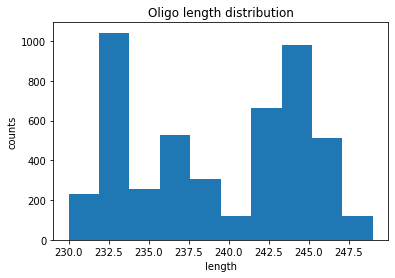

In [8]:
oligo_list = []
length_list = []
for num,subpool_dir in enumerate(glob.glob(PARENT_DIR + '/subpool_*_reverse_translate')):
    os.chdir(subpool_dir)
    order_file = glob.glob(subpool_dir+f'/{OWNER}_{PROJECT}_*_{CHIP_BATCH}')[0]
    fp = open(order_file,'r')
    for line in fp:
        oligo_list.append(line.rstrip())
        length_list.append(len(line.rstrip()))
    fp.close()
print(f'Total number of Oligo {len(oligo_list)}')
fp = open(PARENT_DIR + f'/{OWNER}_{PROJECT}_{CHIP_BATCH}','w')
fp.write('\n'.join(oligo_list))
fp.close()
print(f'Write into file {OWNER}_{PROJECT}_{CHIP_BATCH}.')

plt.hist(length_list)
plt.title('Oligo length distribution')
plt.xlabel('length')
plt.ylabel('counts')

## (Optional) check with David Feldman's scripts

In [242]:
OLIGO_CHECK = '/home/dfeldman/packages/postdoc_stable/scripts/app.sh'
for num,adaptor in enumerate(adaptor_list):
    subpool_dir = PARENT_DIR + '/subpool_{}_reverse_translate'.format(num)
    final_order_file = subpool_dir+'/'+ '_'.join([OWNER,PROJECT,str(num),CHIP_BATCH])
    os.chdir(subpool_dir)
    result = subprocess.run([OLIGO_CHECK,'parse_overlap_oligos',final_order_file], stdout=subprocess.PIPE)